In [1]:
import pandas as pd
import os
import glob

In [9]:
# Define legend categories
legend_categories = {
    'Assault': ['Bangalore', 'Fuse', 'Ash', 'Mad Maggie', 'Ballistic'],
    'Skirmisher': ['Pathfinder', 'Wraith', 'Octane', 'Revenant', 'Horizon', 'Valkyrie', 'Alter'],
    'Recon': ['Bloodhound', 'Crypto', 'Seer', 'Vantage'],
    'Support': ['Gibraltar', 'Lifeline', 'Mirage', 'Loba', 'Newcastle', 'Conduit'],
    'Controller': ['Caustic', 'Wattson', 'Rampart', 'Catalyst']
}
legend_to_category = {legend: role for role, legends in legend_categories.items() for legend in legends}
legends = list(legend_to_category.keys())

In [ ]:
legend_to_category = {legend: role for role, legends in legend_categories.items() for legend in legends}
legends = list(legend_to_category.keys())

base_path = r""
damage_path = os.path.join(base_path, 'Legend Damage')
kills_path = os.path.join(base_path, 'Legend Kills')
matches_path = os.path.join(base_path, 'Legend Matches Played')
wins_path = os.path.join(base_path, 'Legend Wins')

In [17]:
# --- 2. Read and clean data ---
legend_dataframes = []
for legend in legends:
    try:
        legend_damage_file = os.path.join(damage_path, f"{legend}_damage.csv")
        legend_kills_file = os.path.join(kills_path, f"{legend}_kills.csv")
        legend_matches_file = os.path.join(matches_path, f"{legend}_games_played.csv")
        legend_wins_file = os.path.join(wins_path, f"{legend}_wins.csv")
        
        required_files = [legend_damage_file, legend_kills_file, legend_matches_file, legend_wins_file]
        missing_files = [f for f in required_files if not os.path.exists(f)]
        if missing_files:
            print(f"Data files for legend '{legend}' are missing: {missing_files}. Skipping this legend.")
            continue
        
        # Read and clean each file
        def clean_numeric_column(file_path, col_name):
            df = pd.read_csv(file_path, header=None, names=[col_name], skiprows=1)
            df[col_name] = df[col_name].astype(str).str.replace(',', '').str.replace('"', '').str.strip()
            df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
            return df

        df_damage = clean_numeric_column(legend_damage_file, 'Damage')
        df_kills = clean_numeric_column(legend_kills_file, 'Kills')
        df_matches = clean_numeric_column(legend_matches_file, 'Games Played')
        df_wins = clean_numeric_column(legend_wins_file, 'Wins')

        # Combine by index
        df_legend = pd.concat([df_damage.reset_index(drop=True),
                               df_kills.reset_index(drop=True),
                               df_matches.reset_index(drop=True),
                               df_wins.reset_index(drop=True)], axis=1)
        df_legend['legend_name'] = legend
        legend_dataframes.append(df_legend)
    except Exception as e:
        print(f"An error occurred while processing legend '{legend}': {e}")


In [23]:
# --- 3. Combine and preprocess ---
all_legends_df = pd.concat(legend_dataframes, ignore_index=True)
all_legends_df['Legend_Category'] = all_legends_df['legend_name'].map(legend_to_category)

# Remove legends with missing Wins data
legends_missing_wins = ['Ballistic', 'Conduit', 'Alter', 'Newcastle']
all_legends_df = all_legends_df[~all_legends_df['legend_name'].isin(legends_missing_wins)]

# Ensure numeric columns
for col in ['Kills', 'Wins', 'Games Played', 'Damage']:
    all_legends_df[col] = pd.to_numeric(all_legends_df[col], errors='coerce')

all_legends_df

,Damage,Kills,Games Played,Wins,legend_name,Legend_Category
0,1335473024,192425,47418,15355.0,Bangalore,Assault
1,50500034,177520,35645,14088.0,Bangalore,Assault
2,48186631,172382,32770,13041.0,Bangalore,Assault
3,45909908,170902,30597,12675.0,Bangalore,Assault
4,45231990,168326,28659,12637.0,Bangalore,Assault
...,...,...,...,...,...,...
12995,1752140,6767,997,151.0,Catalyst,Controller
12996,1751077,6740,994,150.0,Catalyst,Controller
12997,1750218,6740,990,150.0,Catalyst,Controller
12998,1749964,6737,990,150.0,Catalyst,Controller


In [24]:
# Ensure that columns are numeric, forcing invalid values to NaN
all_legends_df['Kills'] = pd.to_numeric(all_legends_df['Kills'], errors='coerce')
all_legends_df['Wins'] = pd.to_numeric(all_legends_df['Wins'], errors='coerce')
all_legends_df['Games Played'] = pd.to_numeric(all_legends_df['Games Played'], errors='coerce')
all_legends_df['Damage'] = pd.to_numeric(all_legends_df['Damage'], errors='coerce')

# Avoid division by zero and handle NaN
all_legends_df['Kills_per_Win'] = all_legends_df.apply(lambda row: row['Kills'] / row['Wins'] if pd.notna(row['Wins']) and row['Wins'] > 0 else 0, axis=1)
all_legends_df['Kills_per_Match'] = all_legends_df.apply(lambda row: row['Kills'] / row['Games Played'] if pd.notna(row['Games Played']) and row['Games Played'] > 0 else 0, axis=1)
all_legends_df['Damage_per_Match'] = all_legends_df.apply(lambda row: row['Damage'] / row['Games Played'] if pd.notna(row['Games Played']) and row['Games Played'] > 0 else 0, axis=1)

# Group by 'Legend_Category' and calculate the mean of the relevant columns
averaged_stats_df = all_legends_df.groupby('Legend_Category').agg(
    Average_Kills_per_Win=('Kills_per_Win', 'mean'),
    Average_Kills_per_Match=('Kills_per_Match', 'mean'),
    Average_Damage_per_Match=('Damage_per_Match', 'mean')
).reset_index()

# Display the aggregated statistics
print(averaged_stats_df)

  Legend_Category  Average_Kills_per_Win  Average_Kills_per_Match  \
0         Assault              20.182228                 5.317327   
1      Controller              24.195288                 5.117616   
2           Recon              19.728249                 4.704346   
3      Skirmisher              18.516093                 5.040864   
4         Support              16.389824                 4.985961   

   Average_Damage_per_Match  
0               1591.832099  
1               1467.854745  
2               1444.803915  
3               1349.504830  
4               1400.111576  


In [25]:
# List of legends with missing Wins data
legends_missing_wins = ['Ballistic', 'Conduit', 'Alter', 'Newcastle']

# Filter out these legends from the main DataFrame
filtered_legends_df = all_legends_df[~all_legends_df['legend_name'].isin(legends_missing_wins)]

# Verify the exclusion
print(filtered_legends_df['legend_name'].unique())


['Bangalore' 'Fuse' 'Ash' 'Mad Maggie' 'Pathfinder' 'Wraith' 'Octane'
 'Revenant' 'Horizon' 'Valkyrie' 'Bloodhound' 'Crypto' 'Seer' 'Vantage'
 'Gibraltar' 'Lifeline' 'Mirage' 'Loba' 'Caustic' 'Wattson' 'Rampart'
 'Catalyst']


In [27]:
filtered_legends_df

,Damage,Kills,Games Played,Wins,legend_name,Legend_Category,Kills_per_Win,Kills_per_Match,Damage_per_Match
0,1335473024,192425,47418,15355.0,Bangalore,Assault,12.531749,4.058058,28163.841242
1,50500034,177520,35645,14088.0,Bangalore,Assault,12.600795,4.980222,1416.749446
2,48186631,172382,32770,13041.0,Bangalore,Assault,13.218465,5.260360,1470.449527
3,45909908,170902,30597,12675.0,Bangalore,Assault,13.483393,5.585580,1500.470896
4,45231990,168326,28659,12637.0,Bangalore,Assault,13.320092,5.873408,1578.282215
...,...,...,...,...,...,...,...,...,...
12995,1752140,6767,997,151.0,Catalyst,Controller,44.814570,6.787362,1757.412237
12996,1751077,6740,994,150.0,Catalyst,Controller,44.933333,6.780684,1761.646881
12997,1750218,6740,990,150.0,Catalyst,Controller,44.933333,6.808081,1767.896970
12998,1749964,6737,990,150.0,Catalyst,Controller,44.913333,6.805051,1767.640404


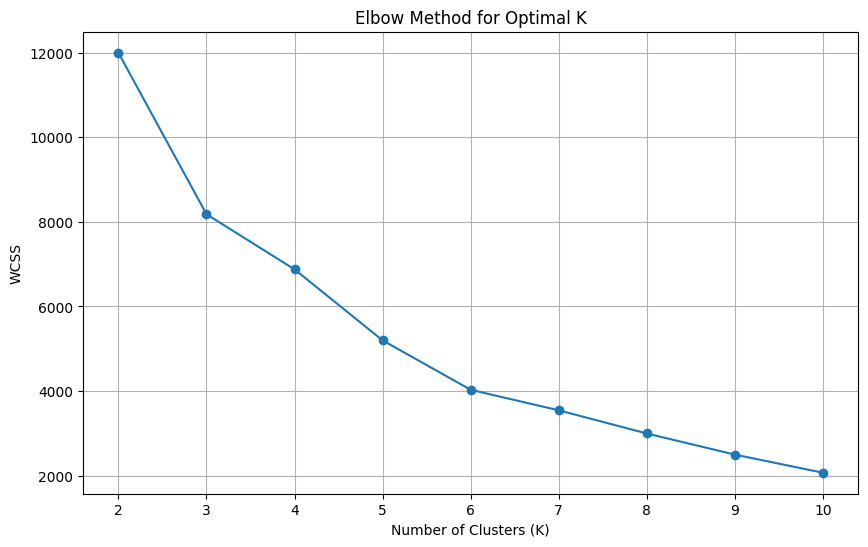

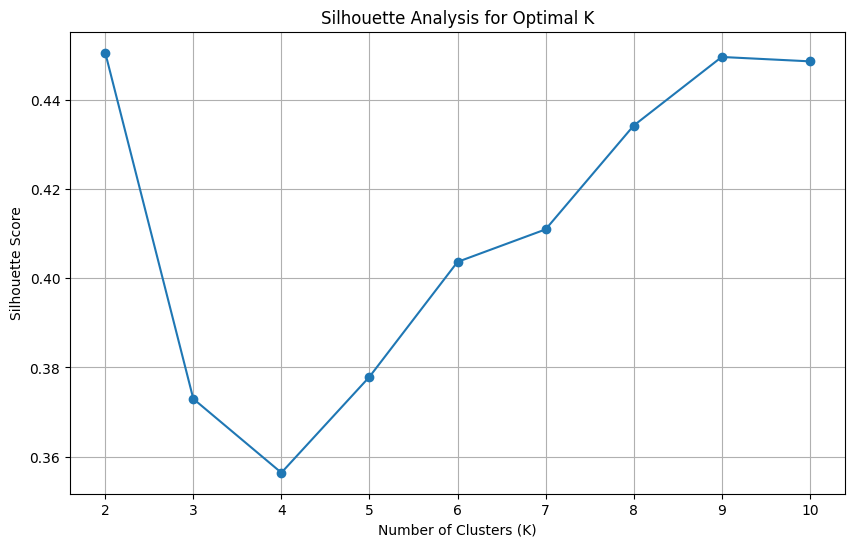

K-Means Clustering - Silhouette Score: 0.377894918219921
K-Means Clustering - Calinski-Harabasz Index: 8049.667355817579
K-Means Clustering - Adjusted Rand Index: 0.14084407921042666
GMM Clustering - Silhouette Score: 0.35054036627898
GMM Clustering - Calinski-Harabasz Index: 6524.664452508829
GMM Clustering - Adjusted Rand Index: 0.15201374146139413
Hierarchical Clustering - Silhouette Score: 0.3537310860494118
Hierarchical Clustering - Calinski-Harabasz Index: 7225.192455377472
Hierarchical Clustering - Adjusted Rand Index: 0.0711857268500829


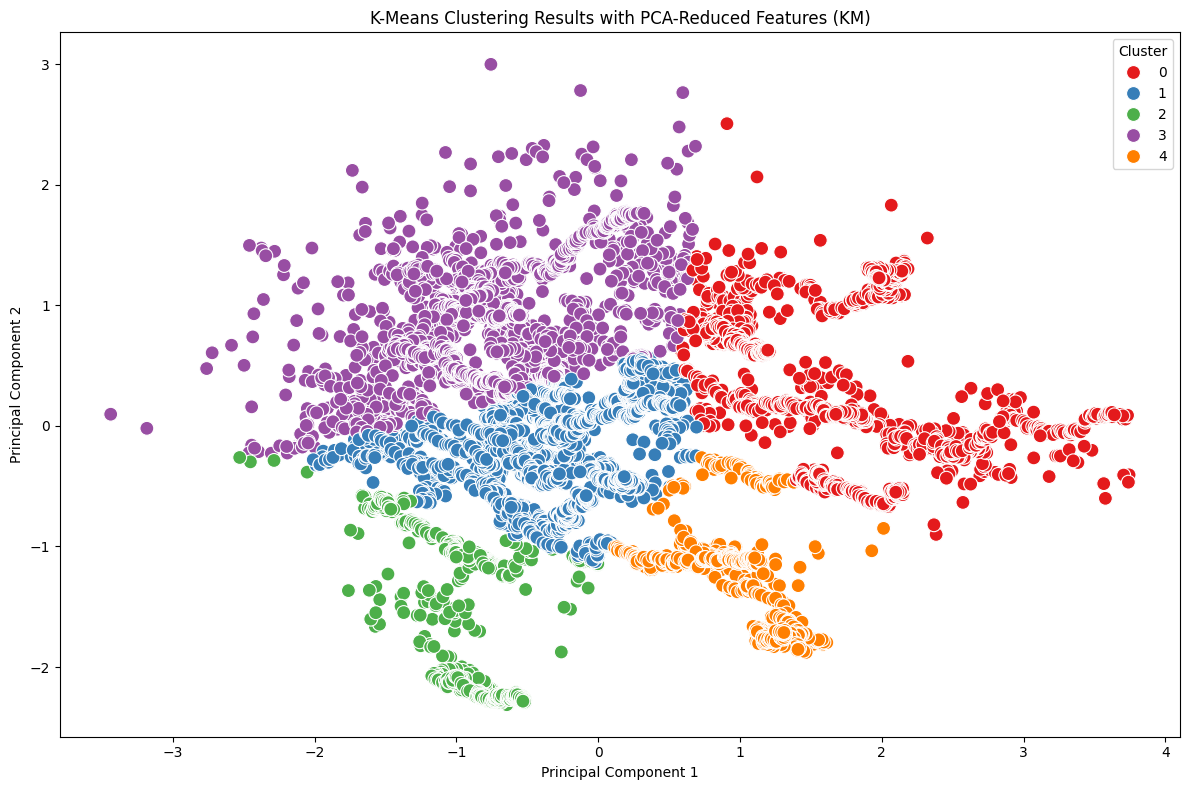

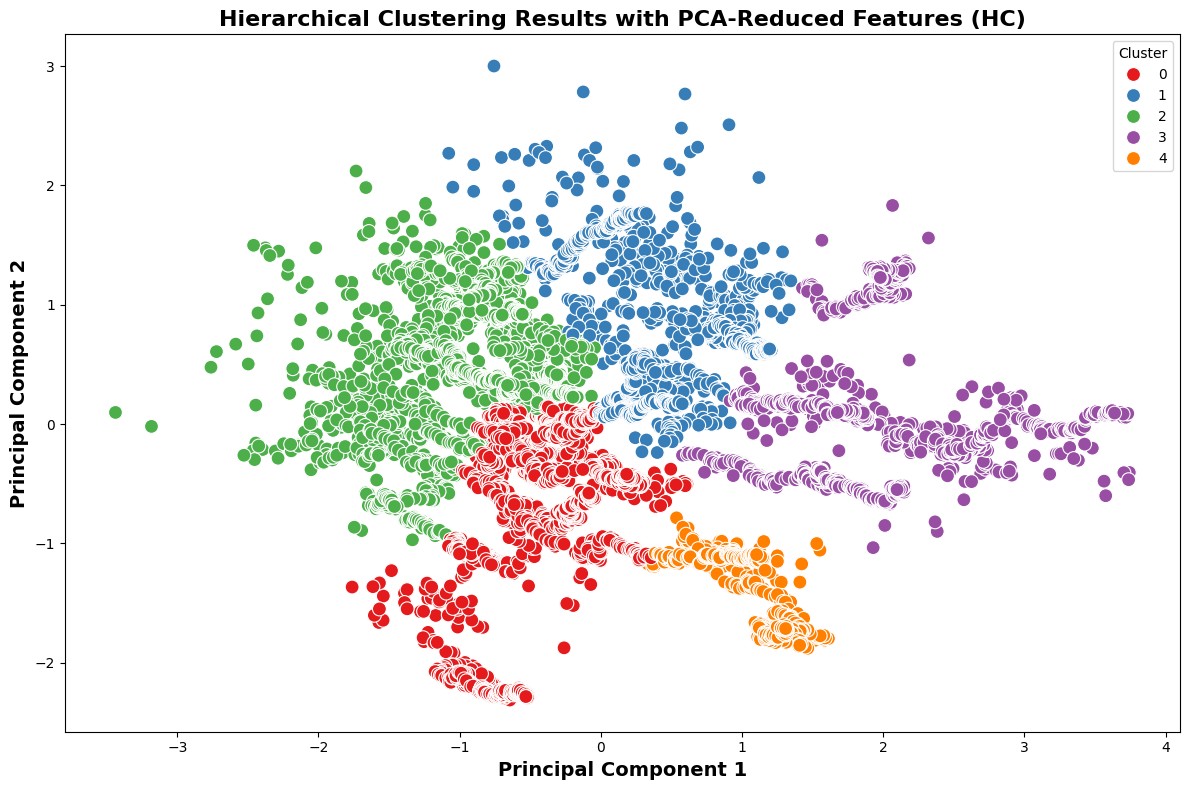

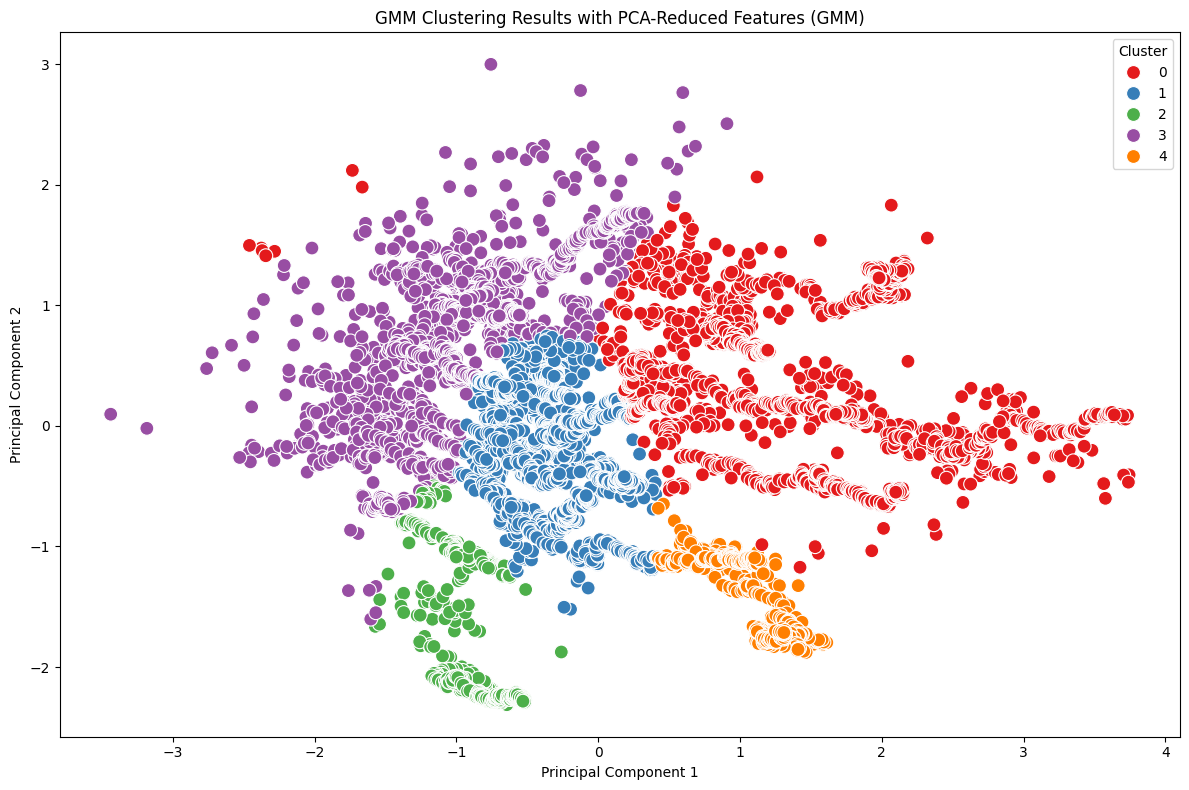

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy import stats

# 1. Data Cleaning
# Exclude incomplete data and remove outliers based only on selected metrics
filtered_legends_df = filtered_legends_df.dropna(subset=['Kills_per_Match', 'Kills_per_Win'])

# Handle Outliers using Z-score (for only Kills_per_Match and Kills_per_Win)
z_scores = np.abs(stats.zscore(filtered_legends_df[['Kills_per_Match', 'Kills_per_Win']]))
filtered_legends_df = filtered_legends_df[(z_scores < 3).all(axis=1)]

# 2. Feature Selection and Scaling
# Only include Kills_per_Match and Kills_per_Win for clustering
features = filtered_legends_df[['Kills_per_Match', 'Kills_per_Win']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 3. PCA for Visualization
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Legend_Category'] = filtered_legends_df['Legend_Category']

# 4. Determine Optimal K using Elbow and Silhouette
wcss = []
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Analysis for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

# Choose K=3 based on previous analysis
optimal_k = 5

# 5. Implement K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
cluster_labels_km = kmeans.fit_predict(scaled_features)
filtered_legends_df['Cluster_KM'] = cluster_labels_km

# 6. Implement Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=optimal_k, covariance_type='full', random_state=42)
cluster_labels_gmm = gmm.fit_predict(scaled_features)
filtered_legends_df['Cluster_GMM'] = cluster_labels_gmm

# 7. Implement Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
cluster_labels_hc = hc.fit_predict(scaled_features)
filtered_legends_df['Cluster_HC'] = cluster_labels_hc

# 8. Evaluate Clustering Results

# K-Means Evaluation
silhouette_km = silhouette_score(scaled_features, cluster_labels_km)
ch_km = calinski_harabasz_score(scaled_features, cluster_labels_km)
ari_km = adjusted_rand_score(filtered_legends_df['Legend_Category'], cluster_labels_km)

print(f'K-Means Clustering - Silhouette Score: {silhouette_km}')
print(f'K-Means Clustering - Calinski-Harabasz Index: {ch_km}')
print(f'K-Means Clustering - Adjusted Rand Index: {ari_km}')

# GMM Evaluation
silhouette_gmm = silhouette_score(scaled_features, cluster_labels_gmm)
ch_gmm = calinski_harabasz_score(scaled_features, cluster_labels_gmm)
ari_gmm = adjusted_rand_score(filtered_legends_df['Legend_Category'], cluster_labels_gmm)

print(f'GMM Clustering - Silhouette Score: {silhouette_gmm}')
print(f'GMM Clustering - Calinski-Harabasz Index: {ch_gmm}')
print(f'GMM Clustering - Adjusted Rand Index: {ari_gmm}')

# Hierarchical Clustering Evaluation
silhouette_hc = silhouette_score(scaled_features, cluster_labels_hc)
ch_hc = calinski_harabasz_score(scaled_features, cluster_labels_hc)
ari_hc = adjusted_rand_score(filtered_legends_df['Legend_Category'], cluster_labels_hc)

print(f'Hierarchical Clustering - Silhouette Score: {silhouette_hc}')
print(f'Hierarchical Clustering - Calinski-Harabasz Index: {ch_hc}')
print(f'Hierarchical Clustering - Adjusted Rand Index: {ari_hc}')

# 9. Visualize Clustering Results (K-Means as Example)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=principal_components[:,0], y=principal_components[:,1], hue=cluster_labels_km, palette='Set1', s=100)
plt.title('K-Means Clustering Results with PCA-Reduced Features (KM)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Visualize Clustering Results (Hierarchical Clustering)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=principal_components[:,0], y=principal_components[:,1], hue=cluster_labels_hc, palette='Set1', s=100)
plt.title('Hierarchical Clustering Results with PCA-Reduced Features (HC)', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component 1', fontsize=14, fontweight='bold')
plt.ylabel('Principal Component 2', fontsize=14, fontweight='bold')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Visualize Clustering Results (GMM)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=principal_components[:,0], y=principal_components[:,1], hue=cluster_labels_gmm, palette='Set1', s=100)
plt.title('GMM Clustering Results with PCA-Reduced Features (GMM)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()



In [34]:
#K means clustering
cluster_profiles_km = filtered_legends_df.groupby('Cluster_KM').agg(
    Mean_Kills_per_Match=('Kills_per_Match', 'mean'),
    Mean_Kills_per_Win=('Kills_per_Win', 'mean'),
).reset_index()
print("cluster_profiles_km")
print(cluster_profiles_km)
#HC clustering
cluster_profiles_hc = filtered_legends_df.groupby('Cluster_HC').agg(
    Mean_Kills_per_Match=('Kills_per_Match', 'mean'),
    Mean_Kills_per_Win=('Kills_per_Win', 'mean'),
).reset_index()
print("cluster_profiles_hc")
print(cluster_profiles_hc)
#GMM clustering
cluster_profiles_gmm = filtered_legends_df.groupby('Cluster_GMM').agg(
    Mean_Kills_per_Match=('Kills_per_Match', 'mean'),
    Mean_Kills_per_Win=('Kills_per_Win', 'mean'),
).reset_index()
print("cluster_profiles_gmm")
print(cluster_profiles_gmm)

cluster_profiles_km
   Cluster_KM  Mean_Kills_per_Match  Mean_Kills_per_Win
0           0              5.624540           23.406779
1           1              4.584455           18.920765
2           2              3.454552           20.113558
3           3              4.848458           16.100772
4           4              6.055402           18.963602
cluster_profiles_hc
   Cluster_HC  Mean_Kills_per_Match  Mean_Kills_per_Win
0           0              4.245251           19.310346
1           1              5.735516           18.128431
2           2              4.727877           16.270281
3           3              6.243778           22.347574
4           4              4.738065           23.396636
cluster_profiles_gmm
   Cluster_GMM  Mean_Kills_per_Match  Mean_Kills_per_Win
0            0              5.541056           23.239409
1            1              4.661199           18.274063
2            2              3.445152           20.280425
3            3              4.919850   


K-Means Clustering - Cluster Composition:
Legend_Category  Assault  Controller  Recon  Skirmisher  Support    All
Cluster_KM                                                             
0                    449         211    559         361        0   1580
1                     10         995    473        1000      488   2966
2                    491          73    406           0        0    970
3                    513         192    241        1043     1346   3335
4                    535          88    318         592      162   1695
All                 1998        1559   1997        2996     1996  10546

K-Means Clustering - Cluster Composition (%):
Legend_Category  Assault  Controller  Recon  Skirmisher  Support
Cluster_KM                                                      
0                  28.42       13.35  35.38       22.85     0.00
1                   0.34       33.55  15.95       33.72    16.45
2                  50.62        7.53  41.86        0.00     0.00
3        

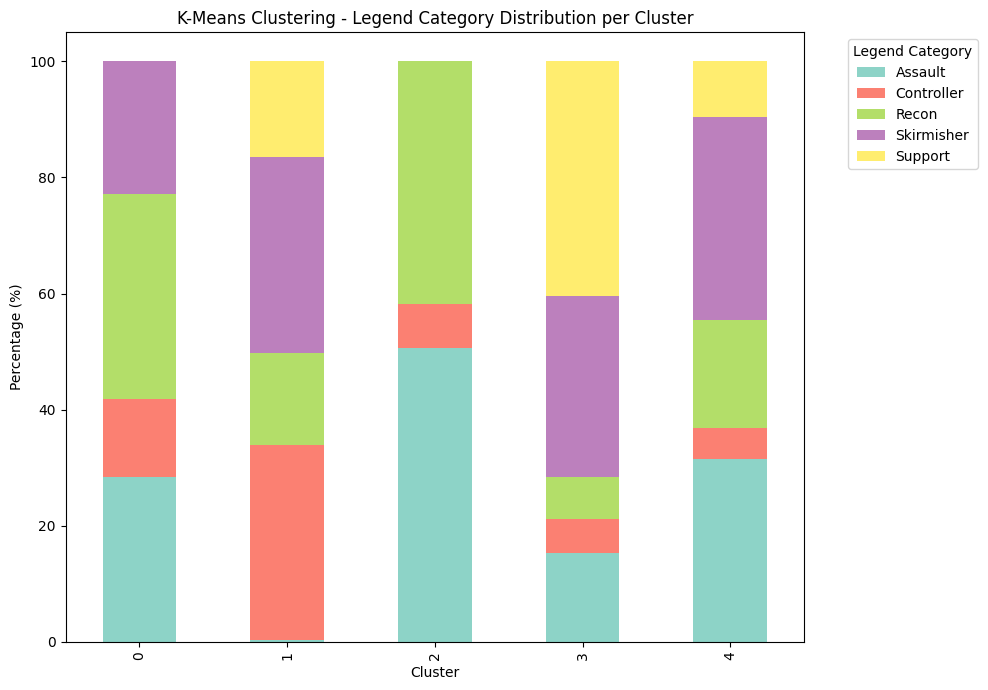


GMM Clustering - Cluster Composition:
Legend_Category  Assault  Controller  Recon  Skirmisher  Support    All
Cluster_GMM                                                            
0                    453         311    612         365        0   1741
1                    329         832    275        1628      626   3690
2                    481          54    365           0        0    900
3                    315         183    388         396     1369   2651
4                    420         179    357         607        1   1564
All                 1998        1559   1997        2996     1996  10546

GMM Clustering - Cluster Composition (%):
Legend_Category  Assault  Controller  Recon  Skirmisher  Support
Cluster_GMM                                                     
0                  26.02       17.86  35.15       20.96     0.00
1                   8.92       22.55   7.45       44.12    16.96
2                  53.44        6.00  40.56        0.00     0.00
3                

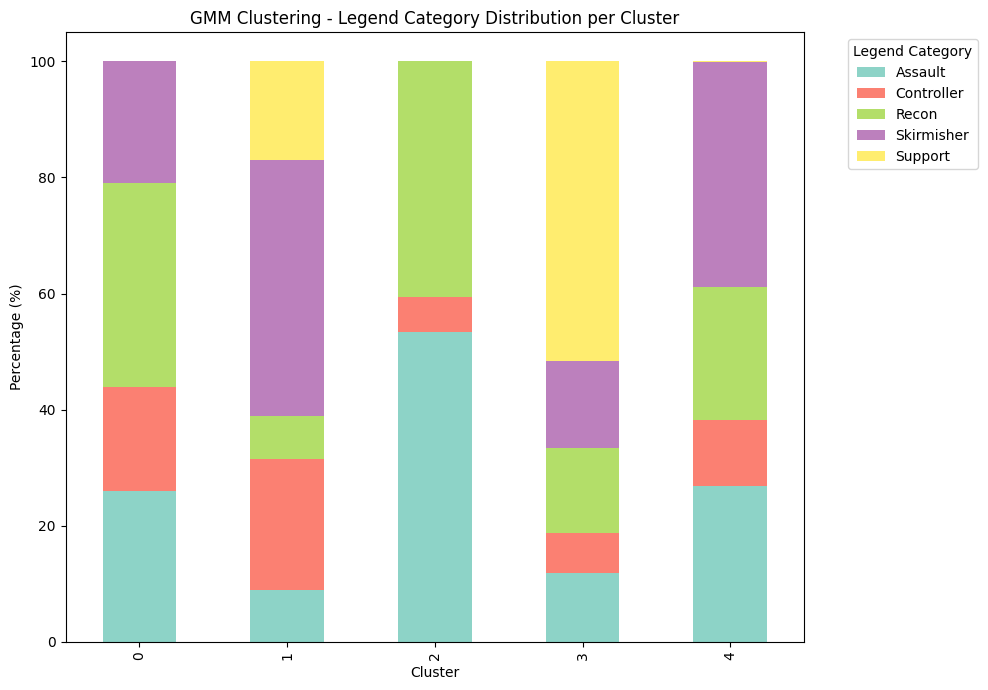


Hierarchical Clustering - Cluster Composition:
Legend_Category  Assault  Controller  Recon  Skirmisher  Support    All
Cluster_HC                                                             
0                    486         858    544         945      420   3253
1                    193         196    365         626      326   1706
2                    515         229    389        1048     1250   3431
3                    804          53    252         377        0   1486
4                      0         223    447           0        0    670
All                 1998        1559   1997        2996     1996  10546

Hierarchical Clustering - Cluster Composition (%):
Legend_Category  Assault  Controller  Recon  Skirmisher  Support
Cluster_HC                                                      
0                  14.94       26.38  16.72       29.05    12.91
1                  11.31       11.49  21.40       36.69    19.11
2                  15.01        6.67  11.34       30.55    36.43

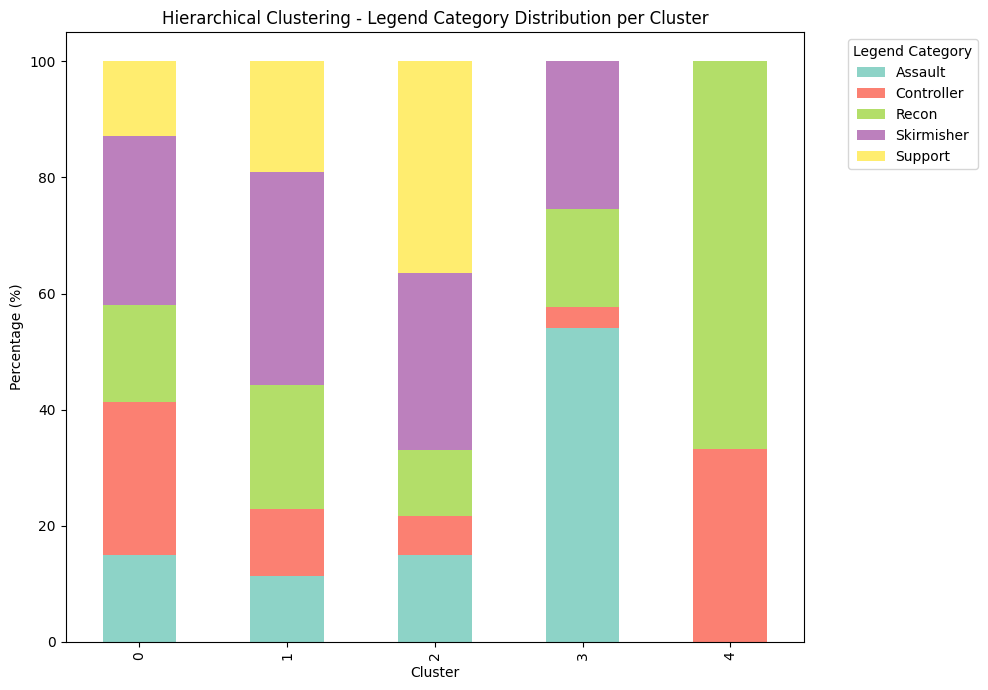

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def cluster_composition_analysis(df, cluster_label, legend_label, method_name):
    """
    Generates cross-tabulation, percentage distribution, and visualization for cluster composition.
    
    Parameters:
    - df: pandas DataFrame containing cluster labels and legend categories.
    - cluster_label: string, column name for cluster labels.
    - legend_label: string, column name for legend categories.
    - method_name: string, name of the clustering method for titles.
    """
    # Cross-tabulation
    crosstab = pd.crosstab(df[cluster_label], df[legend_label], margins=True)
    print(f"\n{method_name} - Cluster Composition:")
    print(crosstab)
    
    # Percentage distribution
    crosstab_percent = pd.crosstab(df[cluster_label], df[legend_label], normalize='index') * 100
    print(f"\n{method_name} - Cluster Composition (%):")
    print(crosstab_percent.round(2))
    
    # Visualization
    crosstab_percent.plot(kind='bar', stacked=True, figsize=(10,7), colormap='Set3')
    plt.title(f'{method_name} - Legend Category Distribution per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Legend Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example Usage:
# Assuming 'filtered_legends_df' is your DataFrame

# K-Means Clustering
cluster_composition_analysis(
    df=filtered_legends_df,
    cluster_label='Cluster_KM',
    legend_label='Legend_Category',
    method_name='K-Means Clustering'
)

# GMM Clustering
cluster_composition_analysis(
    df=filtered_legends_df,
    cluster_label='Cluster_GMM',
    legend_label='Legend_Category',
    method_name='GMM Clustering'
)

# Hierarchical Clustering
cluster_composition_analysis(
    df=filtered_legends_df,
    cluster_label='Cluster_HC',
    legend_label='Legend_Category',
    method_name='Hierarchical Clustering'
)



K-Means Clustering - Cluster Composition:
Legend_Category  Assault  Controller  Recon  Skirmisher  Support    All
Cluster_KM                                                             
0                    851         274    666         840        1   2632
1                    652         471    445        1370     1574   4512
2                    496         905    888         787      425   3501
All                 1999        1650   1999        2997     2000  10645

K-Means Clustering - Cluster Composition (%):
Legend_Category  Assault  Controller  Recon  Skirmisher  Support
Cluster_KM                                                      
0                  32.33       10.41  25.30       31.91     0.04
1                  14.45       10.44   9.86       30.36    34.88
2                  14.17       25.85  25.36       22.48    12.14


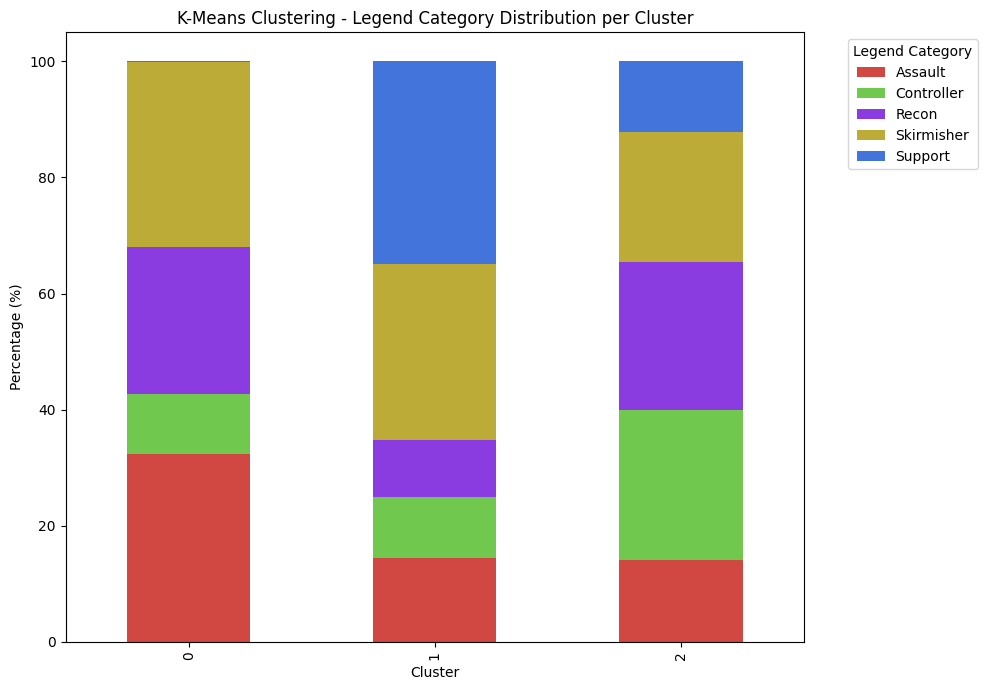


GMM Clustering - Cluster Composition:
Legend_Category  Assault  Controller  Recon  Skirmisher  Support    All
Cluster_GMM                                                            
0                   1005         650    931         993      301   3880
1                    521         688    710        1524     1503   4946
2                    473         312    358         480      196   1819
All                 1999        1650   1999        2997     2000  10645

GMM Clustering - Cluster Composition (%):
Legend_Category  Assault  Controller  Recon  Skirmisher  Support
Cluster_GMM                                                     
0                  25.90       16.75  23.99       25.59     7.76
1                  10.53       13.91  14.36       30.81    30.39
2                  26.00       17.15  19.68       26.39    10.78


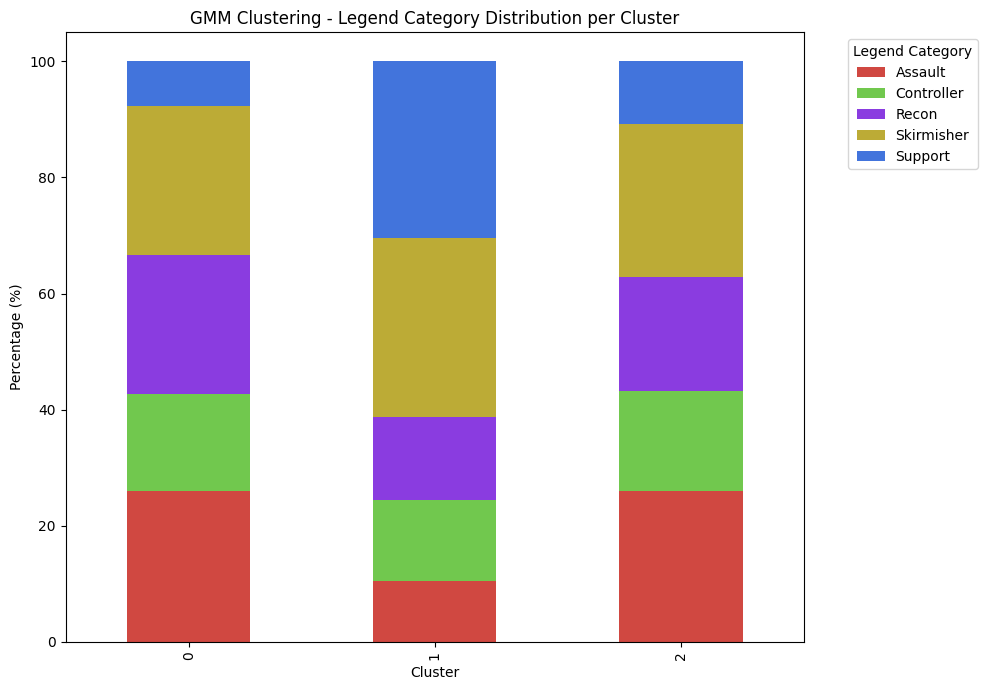


Hierarchical Clustering - Cluster Composition:
Legend_Category  Assault  Controller  Recon  Skirmisher  Support    All
Cluster_HC                                                             
0                    504        1229   1374        1002      476   4585
1                    799         144    269         400        0   1612
2                    696         277    356        1595     1524   4448
All                 1999        1650   1999        2997     2000  10645

Hierarchical Clustering - Cluster Composition (%):
Legend_Category  Assault  Controller  Recon  Skirmisher  Support
Cluster_HC                                                      
0                  10.99       26.80  29.97       21.85    10.38
1                  49.57        8.93  16.69       24.81     0.00
2                  15.65        6.23   8.00       35.86    34.26


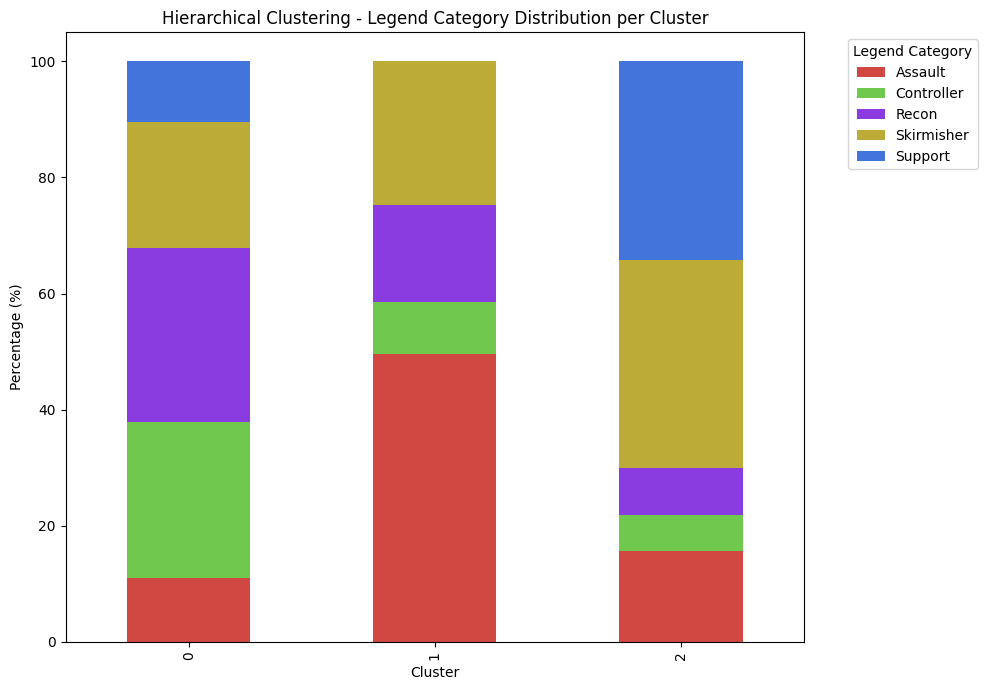

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Define colors for the categories using specified RGB values
category_colors = {
    'Assault': '#D04841',       # rgb(208,72,65)
    'Skirmisher': '#BCAB36',    # rgb(188,171,54)
    'Recon': '#8A3CE0',         # rgb(138,60,224)
    'Controller': '#71C84E',    # rgb(113,200,78)
    'Support': '#4274DC'        # rgb(66,116,220)
}

def cluster_composition_analysis(df, cluster_label, legend_label, method_name):
    """
    Generates cross-tabulation, percentage distribution, and visualization for cluster composition.
    
    Parameters:
    - df: pandas DataFrame containing cluster labels and legend categories.
    - cluster_label: string, column name for cluster labels.
    - legend_label: string, column name for legend categories.
    - method_name: string, name of the clustering method for titles.
    """
    # Cross-tabulation
    crosstab = pd.crosstab(df[cluster_label], df[legend_label], margins=True)
    print(f"\n{method_name} - Cluster Composition:")
    print(crosstab)
    
    # Percentage distribution
    crosstab_percent = pd.crosstab(df[cluster_label], df[legend_label], normalize='index') * 100
    print(f"\n{method_name} - Cluster Composition (%):")
    print(crosstab_percent.round(2))
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Assign colors based on legend categories
    color_list = [category_colors.get(cat, 'grey') for cat in crosstab_percent.columns]
    
    crosstab_percent.plot(
        kind='bar',
        stacked=True,
        color=color_list,
        ax=ax
    )
    
    plt.title(f'{method_name} - Legend Category Distribution per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Legend Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example Usage:
# Assuming 'filtered_legends_df' is your DataFrame

# K-Means Clustering
cluster_composition_analysis(
    df=filtered_legends_df,
    cluster_label='Cluster_KM',
    legend_label='Legend_Category',
    method_name='K-Means Clustering'
)

# GMM Clustering
cluster_composition_analysis(
    df=filtered_legends_df,
    cluster_label='Cluster_GMM',
    legend_label='Legend_Category',
    method_name='GMM Clustering'
)

# Hierarchical Clustering
cluster_composition_analysis(
    df=filtered_legends_df,
    cluster_label='Cluster_HC',
    legend_label='Legend_Category',
    method_name='Hierarchical Clustering'
)


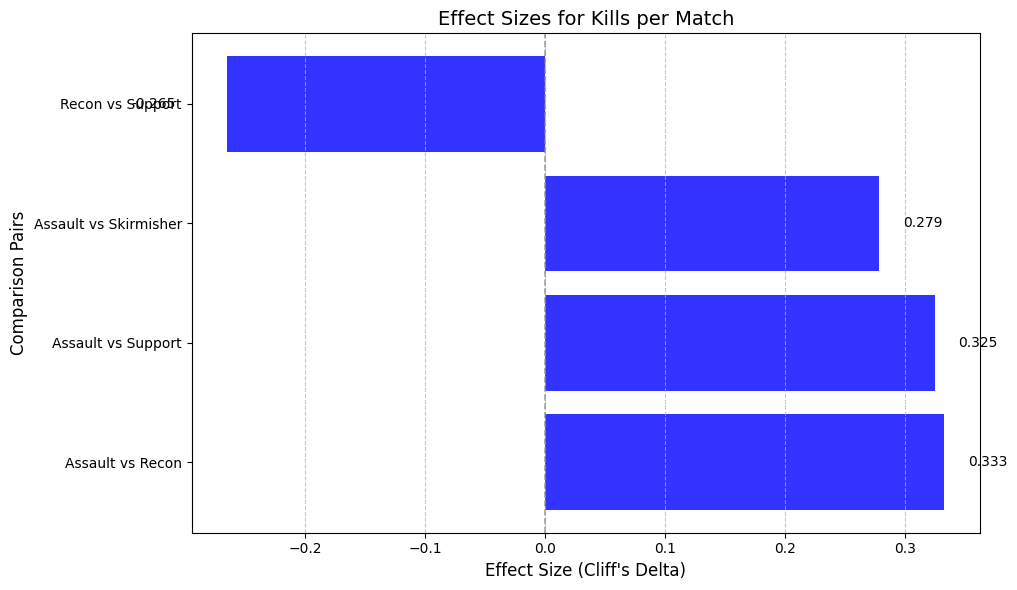

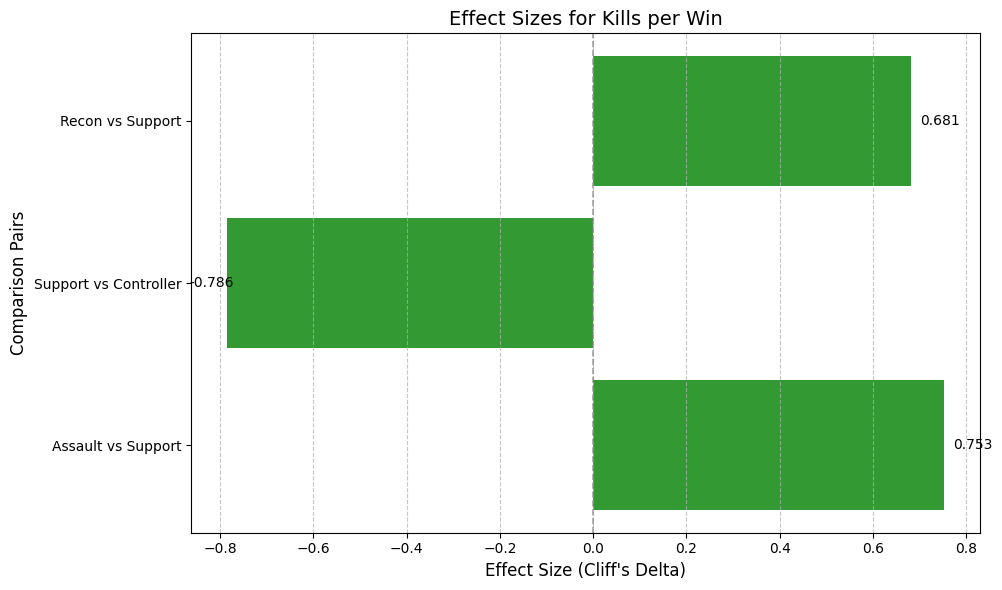

In [21]:
# Data for the horizontal bar chart - Kills per Match
pairs_kills_per_match = [
    "Assault vs Recon",
    "Assault vs Support",
    "Assault vs Skirmisher",
    "Recon vs Support"
]
effect_sizes_kills_per_match = [0.333, 0.325, 0.279, -0.265]

# Data for the horizontal bar chart - Kills per Win
pairs_kills_per_win = [
    "Assault vs Support",
    "Support vs Controller",
    "Recon vs Support"
]
effect_sizes_kills_per_win = [0.753, -0.786, 0.681]

# Create the horizontal bar chart for Kills per Match
plt.figure(figsize=(10, 6))
bars = plt.barh(pairs_kills_per_match, effect_sizes_kills_per_match, color='blue', alpha=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=1.2, alpha=0.7)  # Reference line at 0
plt.xlabel("Effect Size (Cliff's Delta)", fontsize=12)
plt.ylabel("Comparison Pairs", fontsize=12)
plt.title("Effect Sizes for Kills per Match", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02 if width > 0 else width - 0.08,
             bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}",
             va='center',
             fontsize=10)

plt.show()

# Create the horizontal bar chart for Kills per Win
plt.figure(figsize=(10, 6))
bars = plt.barh(pairs_kills_per_win, effect_sizes_kills_per_win, color='green', alpha=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=1.2, alpha=0.7)  # Reference line at 0
plt.xlabel("Effect Size (Cliff's Delta)", fontsize=12)
plt.ylabel("Comparison Pairs", fontsize=12)
plt.title("Effect Sizes for Kills per Win", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02 if width > 0 else width - 0.08,
             bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}",
             va='center',
             fontsize=10)

plt.show()
